# Notebook 04: Consolidación y Análisis Exploratorio (EDA)

**Objetivo:** Crear el *Master Table* (Dataset de Entrenamiento) uniendo las tres fuentes de datos procesadas. Realizar ingeniería de características climáticas avanzadas y un análisis visual de las relaciones clave.

**Mejoras Implementadas:**
1. **Ingeniería Climática:** Cálculo de **Grados-Día** (HDD y CDD) para capturar la intensidad del frío y calor antes de agregar mensualmente.
2. **Limpieza Estructural:** Eliminación de columnas redundantes o vacías (como `nombre_comuna` del socioeconómico) para evitar ruido.
3. **EDA Estratégico:** Visualización enfocada en correlaciones, estacionalidad y desigualdad socioeconómica.

**Output:** `data/processed/master_table.csv`

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Configuración visual
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# RUTAS 
PROCESSED_DIR = os.path.join('..', 'data', 'processed')
FILE_ENERGIA = os.path.join(PROCESSED_DIR, 'consumo_electrico_limpio.csv')
FILE_CLIMA = os.path.join(PROCESSED_DIR, 'clima_diario_limpio.csv')
FILE_SOCIO = os.path.join(PROCESSED_DIR, 'socioeconomico_anual_completo.csv')
OUTPUT_FILE = os.path.join(PROCESSED_DIR, 'master_table.csv')

## 1. Carga de Datos Pre-Procesados

In [18]:
# 1. Energía
print(">>> Cargando Energía...")
df_energia = pd.read_csv(FILE_ENERGIA)
df_energia['fecha'] = pd.to_datetime(df_energia['fecha'])

# 2. Clima (Diario)
print(">>> Cargando Clima...")
df_clima = pd.read_csv(FILE_CLIMA)
df_clima['fecha'] = pd.to_datetime(df_clima['fecha'])

# 3. Socioeconómico
print(">>> Cargando Socioeconómico...")
df_socio = pd.read_csv(FILE_SOCIO)

print(f"  Registros Energía: {len(df_energia)}")
print(f"  Días Clima: {len(df_clima)}")

>>> Cargando Energía...
>>> Cargando Clima...
>>> Cargando Socioeconómico...
  Registros Energía: 74177
  Días Clima: 3940


## 2. Ingeniería de Features Climática (Grados-Día)
Para no perder información al promediar el mes, calculamos primero los **Grados-Día** a nivel diario:
* **HDD (Heating Degree Days):** Intensidad de frío (demanda de calefacción). Base 15°C.
* **CDD (Cooling Degree Days):** Intensidad de calor (demanda de aire acondicionado). Base 24°C.

In [19]:
print(">>> Calculando métricas climáticas avanzadas...")

# Cálculo diario
df_clima['HDD'] = (15 - df_clima['temp_prom']).clip(lower=0)
df_clima['CDD'] = (df_clima['temp_prom'] - 24).clip(lower=0)

# Agregación Mensual
df_clima.set_index('fecha', inplace=True)

df_clima_mensual = df_clima.resample('MS').agg(
    temp_prom_mes=('temp_prom', 'mean'),
    temp_max_abs=('temp_max', 'max'),
    temp_min_abs=('temp_min', 'min'),
    hdd_acumulado=('HDD', 'sum'),  # Suma total de frío del mes
    cdd_acumulado=('CDD', 'sum')   # Suma total de calor del mes
).reset_index()

print("Clima mensual generado (Primeras 3 filas):")
display(df_clima_mensual.head(3))

>>> Calculando métricas climáticas avanzadas...
Clima mensual generado (Primeras 3 filas):


,fecha,temp_prom_mes,temp_max_abs,temp_min_abs,hdd_acumulado,cdd_acumulado
0,2015-01-01,22.260000,35.2,12.4,0.0,1.40
1,2015-02-01,21.394643,35.2,10.2,0.0,3.42
2,2015-03-01,20.988710,35.5,10.6,0.0,0.52


## 3. Fusión (Merge) y Limpieza Final
Unimos las 3 fuentes y limpiamos columnas redundantes.

In [20]:
print(">>> Ejecutando Merge...")

# A) Energía + Clima (Cruce por Fecha)
df_master = pd.merge(df_energia, df_clima_mensual, on='fecha', how='left')

# B) Energía + Socio (Cruce por Comuna y Año)
if 'nombre_comuna' in df_socio.columns:
    df_socio = df_socio.drop(columns=['nombre_comuna'])

df_master = pd.merge(df_master, df_socio, on=['comuna_norm', 'anio'], how='left')

# C) Imputación de Nulos Climáticos (Si faltó algún mes, usar el anterior)
cols_clima = ['temp_prom_mes', 'temp_max_abs', 'temp_min_abs', 'hdd_acumulado', 'cdd_acumulado']
df_master[cols_clima] = df_master[cols_clima].ffill().bfill()

# D) Creación de Quintiles de Ingreso (Feature para análisis)
df_master['quintil'] = pd.qcut(df_master['ingreso_promedio'], 5, labels=['Q1 (Pobre)', 'Q2', 'Q3', 'Q4', 'Q5 (Rico)'])

print(f"Dimensiones finales: {df_master.shape}")
print(f"Nulos restantes:\n{df_master.isna().sum()}")
print(f"Información sobre columnas:\n{df_master.info()}")
print(f"Información estadística sobre columnas:\n{df_master.describe()}")


>>> Ejecutando Merge...
Dimensiones finales: (74177, 18)
Nulos restantes:
fecha                  0
anio                   0
mes                    0
comuna_norm            0
comuna                 0
region                 0
tipo_clientes          0
tarifa                 0
clientes_facturados    0
energia_kwh            0
temp_prom_mes          0
temp_max_abs           0
temp_min_abs           0
hdd_acumulado          0
cdd_acumulado          0
ingreso_promedio       0
tasa_pobreza           0
quintil                0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74177 entries, 0 to 74176
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   fecha                74177 non-null  datetime64[ns]
 1   anio                 74177 non-null  int64         
 2   mes                  74177 non-null  int64         
 3   comuna_norm          74177 non-null  object        
 4   comuna 

## 4. Exportación

In [21]:
# Selección final de columnas limpias
cols_finales = [
    'fecha', 'anio', 'mes', 
    'region', 'comuna', 'comuna_norm',
    'tipo_clientes', 'tarifa', 
    'clientes_facturados', 'energia_kwh', 
    'temp_prom_mes', 'temp_max_abs', 'temp_min_abs', 'hdd_acumulado', 'cdd_acumulado',
    'ingreso_promedio', 'tasa_pobreza', 'quintil'
]

df_master = df_master[cols_finales]

## 5. Análisis Exploratorio (EDA)

In [22]:
display(df_master)

,fecha,anio,mes,region,comuna,comuna_norm,tipo_clientes,tarifa,clientes_facturados,energia_kwh,temp_prom_mes,temp_max_abs,temp_min_abs,hdd_acumulado,cdd_acumulado,ingreso_promedio,tasa_pobreza,quintil
0,2015-01-01,2015,1,Región Metropolitana de Santiago,Maipú,maipu,No Residencial,BT4.1,1.0,1415,22.260000,35.2,12.4,0.00,1.40,433745.237559,0.036145,Q4
1,2015-01-01,2015,1,Región Metropolitana de Santiago,Maipú,maipu,No Residencial,BT3PPP,55.0,198996,22.260000,35.2,12.4,0.00,1.40,433745.237559,0.036145,Q4
2,2015-01-01,2015,1,Región Metropolitana de Santiago,Maipú,maipu,No Residencial,BT3PP,411.0,1635743,22.260000,35.2,12.4,0.00,1.40,433745.237559,0.036145,Q4
3,2015-01-01,2015,1,Región Metropolitana de Santiago,Maipú,maipu,No Residencial,BT4.2,1.0,1915,22.260000,35.2,12.4,0.00,1.40,433745.237559,0.036145,Q4
4,2015-01-01,2015,1,Región Metropolitana de Santiago,María Pinto,maria pinto,No Residencial,AT2PP,1.0,3127,22.260000,35.2,12.4,0.00,1.40,338265.310606,0.058252,Q3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74172,2024-12-01,2024,12,Región Metropolitana de Santiago,Recoleta,recoleta,No Residencial,BT4.3,560.0,2423450,20.360645,35.0,7.8,0.36,1.55,335648.077493,0.045014,Q3
74173,2024-12-01,2024,12,Región Metropolitana de Santiago,San Ramón,san ramon,No Residencial,BT4.3,109.0,261068,20.360645,35.0,7.8,0.36,1.55,291766.365507,0.057488,Q2
74174,2024-12-01,2024,12,Región Metropolitana de Santiago,Lo Espejo,lo espejo,No Residencial,BT4.3,166.0,544728,20.360645,35.0,7.8,0.36,1.55,249684.350394,0.049494,Q1 (Pobre)
74175,2024-12-01,2024,12,Región Metropolitana de Santiago,La Reina,la reina,No Residencial,BT4.3,270.0,1059619,20.360645,35.0,7.8,0.36,1.55,870546.789924,0.016160,Q5 (Rico)


In [23]:
# A. Normalización: KWh por Cliente
df_master['kwh_por_cliente'] = df_master['energia_kwh'] / df_master['clientes_facturados']
df_master['kwh_por_cliente'] = df_master['kwh_por_cliente'].fillna(0).replace([np.inf, -np.inf], 0)

# B. Transformación Logarítmica
df_master['log_energia'] = np.log1p(df_master['energia_kwh'].clip(lower=0))
df_master['log_kwh_por_cliente'] = np.log1p(df_master['kwh_por_cliente'].clip(lower=0))

print("Nuevas columnas creadas: kwh_por_cliente, log_energia")

Nuevas columnas creadas: kwh_por_cliente, log_energia


In [24]:
display(df_master)

,fecha,anio,mes,region,comuna,comuna_norm,tipo_clientes,tarifa,clientes_facturados,energia_kwh,...,temp_max_abs,temp_min_abs,hdd_acumulado,cdd_acumulado,ingreso_promedio,tasa_pobreza,quintil,kwh_por_cliente,log_energia,log_kwh_por_cliente
0,2015-01-01,2015,1,Región Metropolitana de Santiago,Maipú,maipu,No Residencial,BT4.1,1.0,1415,...,35.2,12.4,0.00,1.40,433745.237559,0.036145,Q4,1415.000000,7.255591,7.255591
1,2015-01-01,2015,1,Región Metropolitana de Santiago,Maipú,maipu,No Residencial,BT3PPP,55.0,198996,...,35.2,12.4,0.00,1.40,433745.237559,0.036145,Q4,3618.109091,12.201045,8.193983
2,2015-01-01,2015,1,Región Metropolitana de Santiago,Maipú,maipu,No Residencial,BT3PP,411.0,1635743,...,35.2,12.4,0.00,1.40,433745.237559,0.036145,Q4,3979.909976,14.307608,8.289266
3,2015-01-01,2015,1,Región Metropolitana de Santiago,Maipú,maipu,No Residencial,BT4.2,1.0,1915,...,35.2,12.4,0.00,1.40,433745.237559,0.036145,Q4,1915.000000,7.557995,7.557995
4,2015-01-01,2015,1,Región Metropolitana de Santiago,María Pinto,maria pinto,No Residencial,AT2PP,1.0,3127,...,35.2,12.4,0.00,1.40,338265.310606,0.058252,Q3,3127.000000,8.048149,8.048149
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74172,2024-12-01,2024,12,Región Metropolitana de Santiago,Recoleta,recoleta,No Residencial,BT4.3,560.0,2423450,...,35.0,7.8,0.36,1.55,335648.077493,0.045014,Q3,4327.589286,14.700703,8.372997
74173,2024-12-01,2024,12,Región Metropolitana de Santiago,San Ramón,san ramon,No Residencial,BT4.3,109.0,261068,...,35.0,7.8,0.36,1.55,291766.365507,0.057488,Q2,2395.119266,12.472540,7.781606
74174,2024-12-01,2024,12,Región Metropolitana de Santiago,Lo Espejo,lo espejo,No Residencial,BT4.3,166.0,544728,...,35.0,7.8,0.36,1.55,249684.350394,0.049494,Q1 (Pobre),3281.493976,13.208044,8.096359
74175,2024-12-01,2024,12,Región Metropolitana de Santiago,La Reina,la reina,No Residencial,BT4.3,270.0,1059619,...,35.0,7.8,0.36,1.55,870546.789924,0.016160,Q5 (Rico),3924.514815,13.873421,8.275253


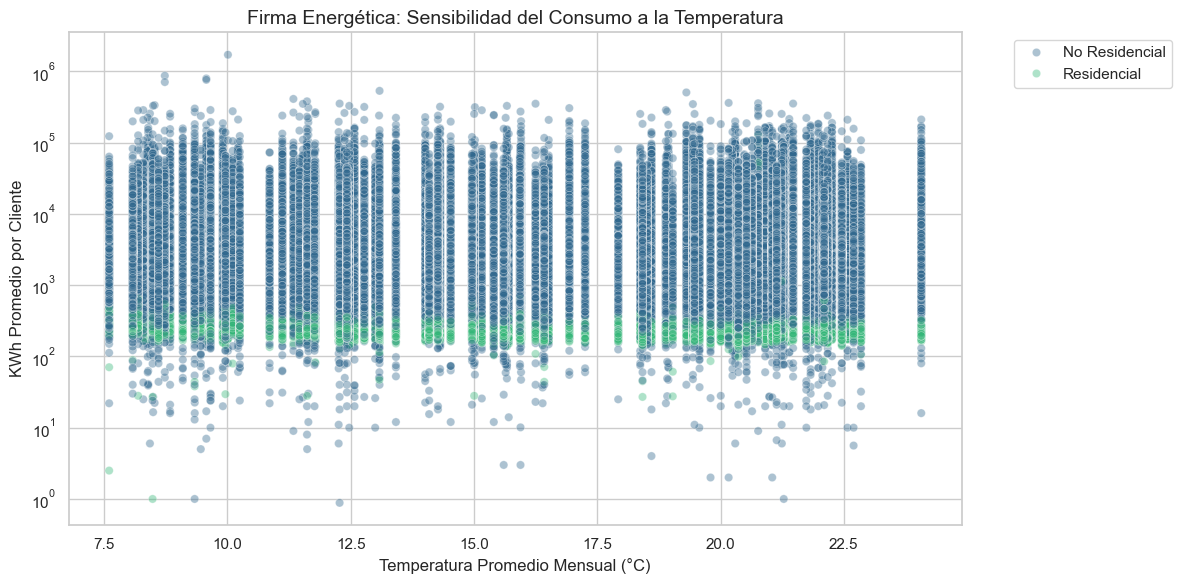

C:\Users\thoma\AppData\Local\Temp\ipykernel_10936\2623525448.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


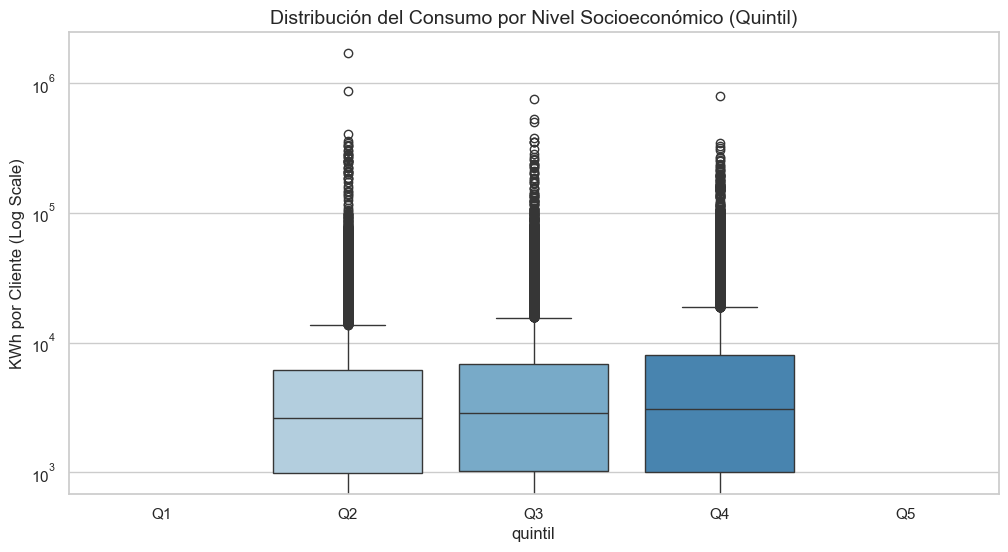

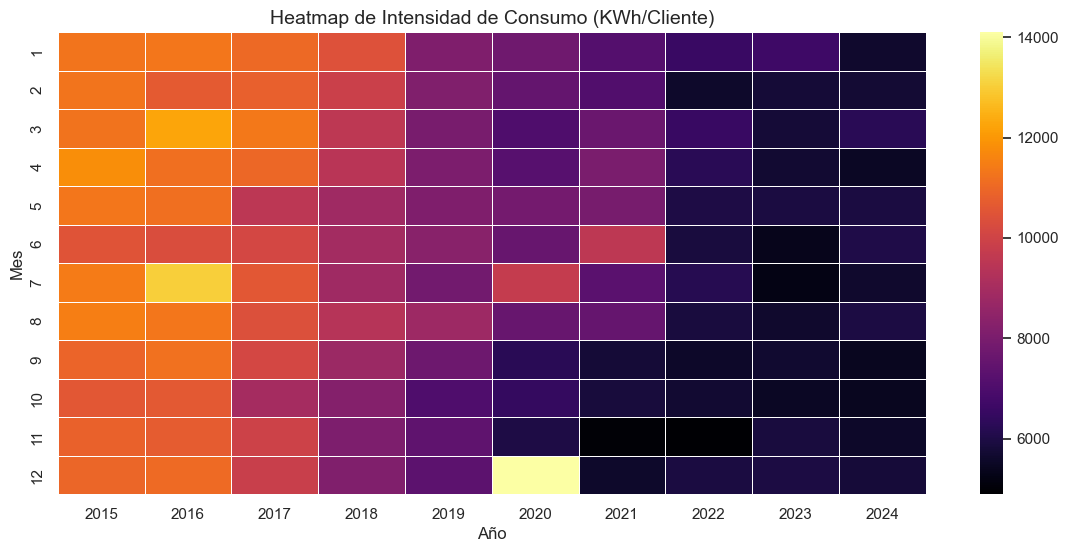

In [25]:
sns.set_theme(style="whitegrid")
plt.figure(figsize=(12, 6))
sns.scatterplot(
    data=df_master,
    x='temp_prom_mes',
    y='kwh_por_cliente',
    hue='tipo_clientes',
    alpha=0.4,
    palette='viridis'
)
plt.title('Firma Energética: Sensibilidad del Consumo a la Temperatura', fontsize=14)
plt.xlabel('Temperatura Promedio Mensual (°C)')
plt.ylabel('KWh Promedio por Cliente')
plt.yscale('log') # Escala logarítmica ayuda a ver mejor si hay mucha dispersión
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(
    data=df_master,
    x='quintil',
    y='kwh_por_cliente',
    order=['Q1', 'Q2', 'Q3', 'Q4', 'Q5'],
    palette="Blues"
)
plt.title('Distribución del Consumo por Nivel Socioeconómico (Quintil)', fontsize=14)
plt.yscale('log')
plt.ylabel('KWh por Cliente (Log Scale)')
plt.show()

pivot_heatmap = df_master.groupby(['anio', 'mes'])['kwh_por_cliente'].mean().unstack(level=0)

plt.figure(figsize=(14, 6))
sns.heatmap(pivot_heatmap, cmap='inferno', annot=False, linewidths=.5)
plt.title('Heatmap de Intensidad de Consumo (KWh/Cliente)', fontsize=14)
plt.xlabel('Año')
plt.ylabel('Mes')
plt.show()

Con respecto al gráfico de la firma energética ,a primera vista no hay una tendencia clara de aumento/disminución del consumo con la temperatura.
Esto puede indicar que la eficiencia energética o los patrones de uso no dependen fuertemente del clima, o que la variable temperatura sola no explica el consumo. Además la distribución por nivel socioeconimico es bastante pareja esto sugiere que el nivel socioeconómico NO es el principal determinante del consumo básico doméstico, por otro lado el Heatmap nos muestra que el consumo energético por cliente ha disminuido de forma notable desde 2018, con un punto máximo anómalo en diciembre de 2020 y una etapa de mínimo histórico en 2022. Esto puede indicar mejoras de eficiencia, cambios en hábitos de consumo, efectos económicos o impacto de la pandemia.

Correlación con Temperatura del Mismo Mes: 0.0050
Correlación con Temperatura del Mes Anterior: 0.0062


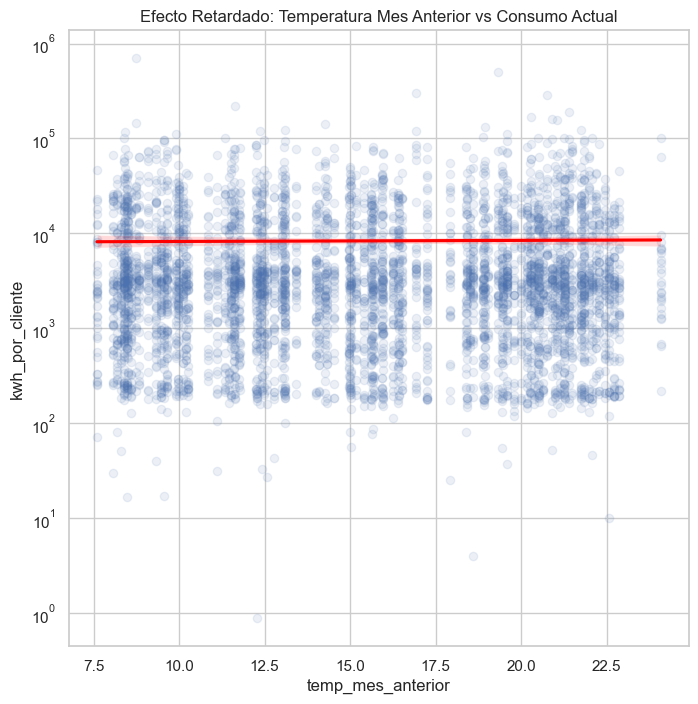

In [26]:
# 5.1 Correlaciones
df_lag = df_master.sort_values(['comuna', 'fecha']).copy()
df_lag['temp_mes_anterior'] = df_lag.groupby('comuna')['temp_prom_mes'].shift(1)

corr_actual = df_lag['kwh_por_cliente'].corr(df_lag['temp_prom_mes'])
corr_lag = df_lag['kwh_por_cliente'].corr(df_lag['temp_mes_anterior'])

print(f"Correlación con Temperatura del Mismo Mes: {corr_actual:.4f}")
print(f"Correlación con Temperatura del Mes Anterior: {corr_lag:.4f}")

# Visualización del Lag
plt.figure(figsize=(8, 8))
sns.regplot(
    data=df_lag.sample(5000), # Muestreo para que no sea tan lento graficar
    x='temp_mes_anterior',
    y='kwh_por_cliente',
    scatter_kws={'alpha':0.1},
    line_kws={'color':'red'}
)
plt.title('Efecto Retardado: Temperatura Mes Anterior vs Consumo Actual')
plt.yscale('log')
plt.show()

El consumo actual muestra un leve aumento cuando la temperatura del mes anterior fue más alta, pero la relación es muy débil y con muchísima variabilidad, lo cual indica que la temperatura del mes pasado no es un predictor fuerte del consumo actual.

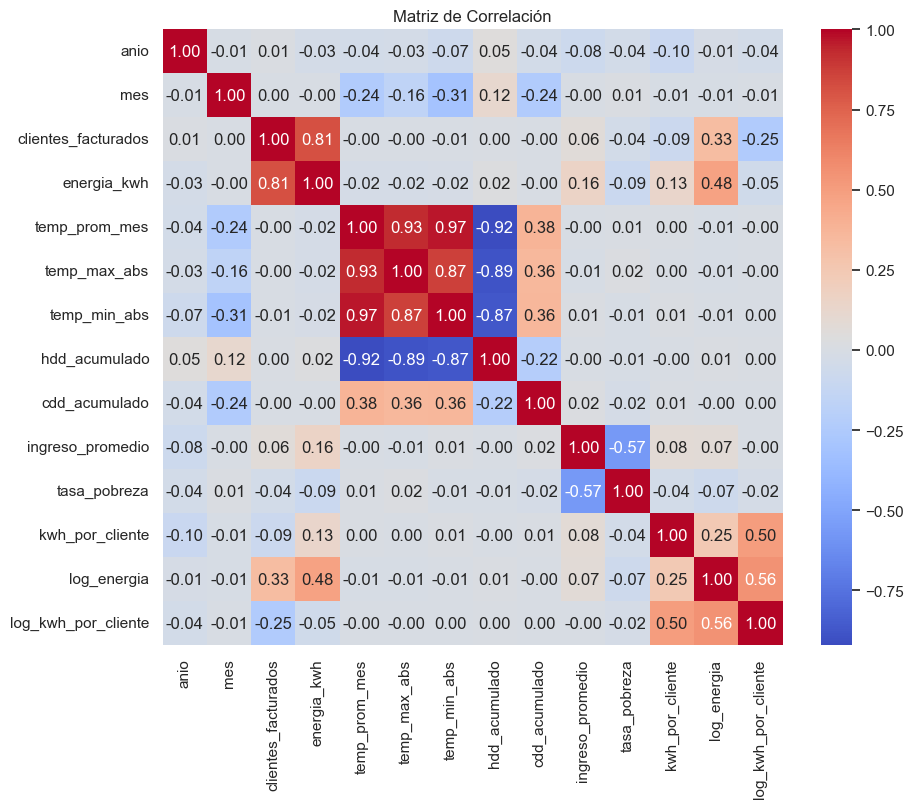

In [27]:
plt.figure(figsize=(10, 8))
cols_num = df_master.select_dtypes(include=['float64', 'int64']).columns
sns.heatmap(df_master[cols_num].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Matriz de Correlación")
plt.show()

Las variables de temperatura presentan correlaciones extremadamente altas entre sí, lo que indica una fuerte redundancia entre ellas, los indicadores HDD disminuyen a medida que aumenta la temperatura, mientras que los CDD tienden a incrementarse, por lo que las variables se comportan como deberian. Por otro lado, la energía total consumida se encuentra fuertemente explicada por la cantidad de clientes, mientras que el consumo por cliente no muestra relaciones lineales significativas con variables climáticas ni socioeconómicas. La transformación logarítmica mejora parcialmente la relación entre la energía total y el consumo por cliente, pero en conjunto los resultados indican que el clima no explica de manera adecuada el consumo individual, sugiriendo que su influencia es débil.

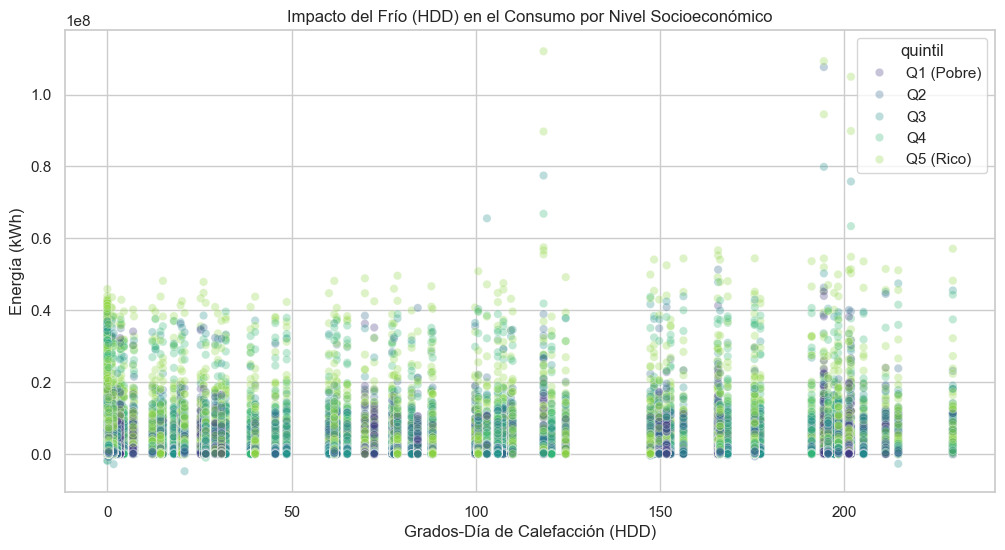

In [28]:
# 5.2 Consumo vs Frío (HDD)
plt.figure(figsize=(12, 6))
sns.scatterplot(data=df_master, x='hdd_acumulado', y='energia_kwh', hue='quintil', alpha=0.3, palette='viridis')
plt.title("Impacto del Frío (HDD) en el Consumo por Nivel Socioeconómico")
plt.xlabel("Grados-Día de Calefacción (HDD)")
plt.ylabel("Energía (kWh)")
plt.show()

El gráfico muestra que el consumo de energía presenta una alta dispersión en todos los niveles de frío medido por HDD. Aunque los hogares de mayores ingresos (Q4 y Q5) alcanzan consumos máximos más altos que los quintiles más pobres, todos los grupos muestran patrones igualmente dispersos, lo que sugiere que el frío por sí solo no es un determinante fuerte del consumo. En conjunto, los resultados indican que el nivel socioeconómico influye más en la magnitud del consumo que las variaciones de HDD.

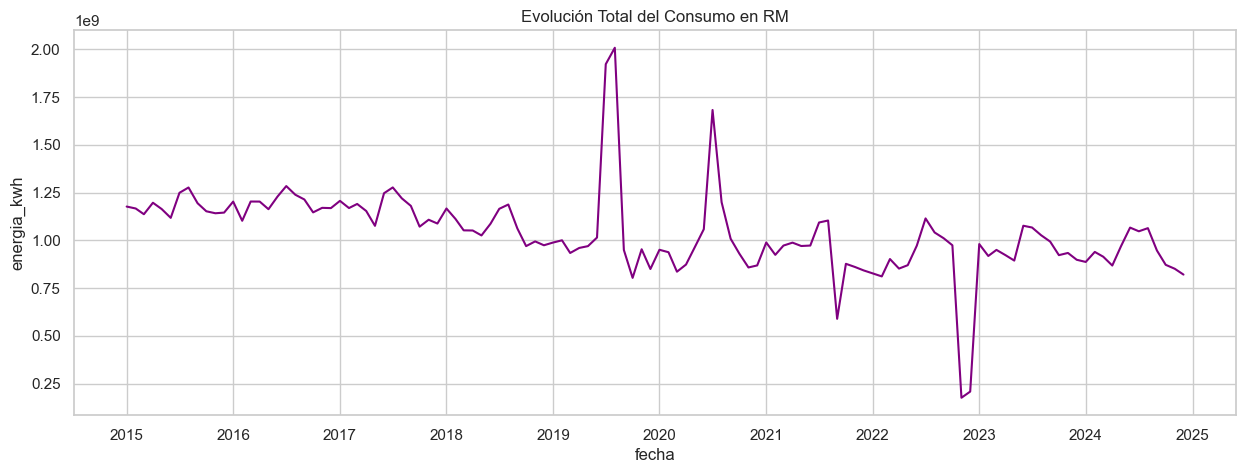

In [29]:
# 5.3 Serie Temporal Agregada
df_ts = df_master.groupby('fecha')['energia_kwh'].sum().reset_index()
plt.figure(figsize=(15, 5))
sns.lineplot(data=df_ts, x='fecha', y='energia_kwh', color='purple')
plt.title("Evolución Total del Consumo en RM")
plt.show()

El consumo eléctrico total de la Región Metropolitana se mantiene relativamente estable entre 2015 y 2025, con valores cercanos a (1.0–1.2) x 10^9 kWh. A lo largo del período se observan algunos picos y caídas, especialmente alrededor de 2020–2023, probablemente asociados los efectos de la pandemia y ajustes posteriores en la actividad económica. Más allá de estas anomalías puntuales, la serie no muestra una tendencia creciente sostenida, por el contrario, hacia 2024–2025 se aprecia una leve disminución, lo que sugiere un estancamiento en la demanda eléctrica regional.

In [30]:
display(df_master)
df_master.to_csv(OUTPUT_FILE, index=False)
print(f"Master Table guardada en: {OUTPUT_FILE}")

,fecha,anio,mes,region,comuna,comuna_norm,tipo_clientes,tarifa,clientes_facturados,energia_kwh,...,temp_max_abs,temp_min_abs,hdd_acumulado,cdd_acumulado,ingreso_promedio,tasa_pobreza,quintil,kwh_por_cliente,log_energia,log_kwh_por_cliente
0,2015-01-01,2015,1,Región Metropolitana de Santiago,Maipú,maipu,No Residencial,BT4.1,1.0,1415,...,35.2,12.4,0.00,1.40,433745.237559,0.036145,Q4,1415.000000,7.255591,7.255591
1,2015-01-01,2015,1,Región Metropolitana de Santiago,Maipú,maipu,No Residencial,BT3PPP,55.0,198996,...,35.2,12.4,0.00,1.40,433745.237559,0.036145,Q4,3618.109091,12.201045,8.193983
2,2015-01-01,2015,1,Región Metropolitana de Santiago,Maipú,maipu,No Residencial,BT3PP,411.0,1635743,...,35.2,12.4,0.00,1.40,433745.237559,0.036145,Q4,3979.909976,14.307608,8.289266
3,2015-01-01,2015,1,Región Metropolitana de Santiago,Maipú,maipu,No Residencial,BT4.2,1.0,1915,...,35.2,12.4,0.00,1.40,433745.237559,0.036145,Q4,1915.000000,7.557995,7.557995
4,2015-01-01,2015,1,Región Metropolitana de Santiago,María Pinto,maria pinto,No Residencial,AT2PP,1.0,3127,...,35.2,12.4,0.00,1.40,338265.310606,0.058252,Q3,3127.000000,8.048149,8.048149
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74172,2024-12-01,2024,12,Región Metropolitana de Santiago,Recoleta,recoleta,No Residencial,BT4.3,560.0,2423450,...,35.0,7.8,0.36,1.55,335648.077493,0.045014,Q3,4327.589286,14.700703,8.372997
74173,2024-12-01,2024,12,Región Metropolitana de Santiago,San Ramón,san ramon,No Residencial,BT4.3,109.0,261068,...,35.0,7.8,0.36,1.55,291766.365507,0.057488,Q2,2395.119266,12.472540,7.781606
74174,2024-12-01,2024,12,Región Metropolitana de Santiago,Lo Espejo,lo espejo,No Residencial,BT4.3,166.0,544728,...,35.0,7.8,0.36,1.55,249684.350394,0.049494,Q1 (Pobre),3281.493976,13.208044,8.096359
74175,2024-12-01,2024,12,Región Metropolitana de Santiago,La Reina,la reina,No Residencial,BT4.3,270.0,1059619,...,35.0,7.8,0.36,1.55,870546.789924,0.016160,Q5 (Rico),3924.514815,13.873421,8.275253


Master Table guardada en: ..\data\processed\master_table.csv
